## IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0
import folium # map rendering library

!pip install lxml
import lxml

!pip install geopy
from geopy.geocoders import Nominatim

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

## NYC GEODATA 

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
ny_neighborhoods_data = newyork_data['features']

##### TRANSFORM DATA INTO PANDAS DATAFRAME

In [5]:
# define the dataframe columns
ny_column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=ny_column_names)

In [6]:
for data in ny_neighborhoods_data:
    borough = ny_neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
ny_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
print('New York has {} neighborhoods.'.format(
        ny_neighborhoods.shape[0]
    )
)

New York has 306 neighborhoods.


306 is too many neighborhoods compared to Toronto. Let's just look at Manhattan & Brooklyn

In [9]:
man_neighborhoods = ny_neighborhoods[(ny_neighborhoods['Borough'] >= 'Brooklyn') & (ny_neighborhoods['Borough'] <= 'Manhattan')].reset_index(drop=True)
man_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bensonhurst,40.611009,-73.995180
3,Brooklyn,Sunset Park,40.645103,-74.010316
4,Brooklyn,Greenpoint,40.730201,-73.954241


In [10]:
print('Manhattan & Brooklyn has {} neighborhoods.'.format(
        man_neighborhoods.shape[0]
    )
)

Manhattan & Brooklyn has 110 neighborhoods.


##### USE GEOPY TO GET THE LATITUDE & LONGITUDE OF MANHATTAN

In [11]:
man_address = 'Manhattan, NY'

man_geolocator = Nominatim(user_agent="man_explorer")
man_location = man_geolocator.geocode(man_address)
man_latitude = man_location.latitude
man_longitude = man_location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(man_latitude, man_longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


## TOR GEODATA

In [12]:
tor_df=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
tor_df = tor_df[tor_df.Borough != 'Not assigned']
tor_df['Neighbourhood']=tor_df['Neighbourhood'].replace('Not assigned', tor_df['Borough'])
tor_df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


##### GET LATITUDE AND LONGITUDE DATA FOR TORONTO NEIGHBORHOODS

In [13]:
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
df_tor = tor_df.merge(df_geo, on="Postal Code", how = 'inner')
df_tor.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


##### USE GEOPY TO GET THE LATITUDE & LONGITUDE OF TORONTO

In [14]:
tor_address = 'Toronto, ON'

tor_geolocator = Nominatim(user_agent="tor_explorer")
tor_location = tor_geolocator.geocode(tor_address)
tor_latitude = tor_location.latitude
tor_longitude = tor_location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(tor_latitude, tor_longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [15]:
print('Toronto has {} neighborhoods.'.format(
        df_tor.shape[0]
    )
)

Toronto has 103 neighborhoods.


## FOURSQUARE ANALYSIS

In [16]:
CLIENT_ID = '01CPVL0CZ50XYMQHHMSPW04WQPY3UTOTUVKI1FC0FDBTEYQM'
CLIENT_SECRET = 'QRJE0EEDHN2V1YYOOJHXR3E5GNYWUGA4RZZMDC55SWFUUWIK' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 01CPVL0CZ50XYMQHHMSPW04WQPY3UTOTUVKI1FC0FDBTEYQM
CLIENT_SECRET:QRJE0EEDHN2V1YYOOJHXR3E5GNYWUGA4RZZMDC55SWFUUWIK


##### FUNCTION TO GET 100 VENUES FOR EACH NEIGHBORHOOD

In [17]:
LIMIT = 100

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
man_venues = getNearbyVenues(names=man_neighborhoods['Neighborhood'],
                                   latitudes=man_neighborhoods['Latitude'],
                                   longitudes=man_neighborhoods['Longitude']
                                  )

Marble Hill
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho

In [20]:
tor_venues = getNearbyVenues(names=df_tor['Neighbourhood'],
                                   latitudes=df_tor['Latitude'],
                                   longitudes=df_tor['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

##### ADD CITY COLUMN TO MAN_VENUES & TOR_VENUES DATAFRAMES

In [21]:
man_venues['City'] = 'Manhattan'
print(man_venues.shape)
man_venues.head()

(5949, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place,Manhattan
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio,Manhattan
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner,Manhattan
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop,Manhattan
4,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym,Manhattan


In [22]:
tor_venues['City'] = 'Toronto' 
print(tor_venues.shape)
tor_venues.head()

(2152, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,Toronto
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,Toronto
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,Toronto
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant,Toronto
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop,Toronto


##### Concatenate Manhattan and Toronto venues in to 1 Dataframe

In [23]:
mantor_venues = pd.concat([man_venues, tor_venues])
mantor_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place,Manhattan
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio,Manhattan
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner,Manhattan
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop,Manhattan
4,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym,Manhattan


In [24]:
print(mantor_venues.shape)

(8101, 8)


In [25]:
print('There are {} uniques categories.'.format(len(mantor_venues['Venue Category'].unique())))

There are 428 uniques categories.


##### Analyze each neighborhood in combined data frame

In [26]:
# one hot encoding
mantor_onehot = pd.get_dummies(mantor_venues[['Venue Category']], prefix="", prefix_sep="")

# add Zeighborhood column back to dataframe, Z is to makesure it's the last item in the list
mantor_onehot['Zeighborhood'] = mantor_venues['Neighborhood'] 

# move Zeighborhood column to the first column
mantor_fixed_columns_zeighborhood = [mantor_onehot.columns[-1]] + list(mantor_onehot.columns[:-1])
mantor_onehot = mantor_onehot[mantor_fixed_columns_zeighborhood]

mantor_onehot.head()

,Zeighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum

In [27]:
# add Zity column back to dataframe, Z is to makesure it's the last item in the list
mantor_onehot['Zity'] = mantor_venues['City'] 

# move Zeighborhood column to the first column
mantor_fixed_columns_zity = [mantor_onehot.columns[-1]] + list(mantor_onehot.columns[:-1])
mantor_onehot = mantor_onehot[mantor_fixed_columns_zity]

mantor_onehot.head()

,Zity,Zeighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,M

##### THIS IS WHERE ONE NEEDS TO MAKE A DECISION ON WHICH PATH TO FOLLOW
KMEANS OR K NEAREST NEIGHBOR

##### VERSION 1: K-MEANS

In [28]:
mantor_grouped = mantor_onehot.groupby(['Zity', 'Zeighborhood']).mean().reset_index()
mantor_grouped.head()

,Zity,Zeighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,M

Cluster Neighborhoods

In [29]:
# set number of clusters
kclusters = 20

mantor_grouped_clustering = mantor_grouped.drop(['Zity', 'Zeighborhood'], 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=12, random_state=0).fit(mantor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels [0:10]

array([13,  5,  5,  5, 13, 13,  5, 13, 13, 13], dtype=int32)

In [30]:
# add clustering labels
mantor_cluster = mantor_grouped
mantor_cluster["Cluster"] = labels

mantor_fixed_columns_cluster = [mantor_cluster.columns[-1]] + list(mantor_cluster.columns[:-1])
mantor_cluster = mantor_cluster[mantor_fixed_columns_cluster]

mantor_cluster.head()

,Cluster,Zity,Zeighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving 

In [32]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b40fa1b38>]],
      dtype=object)

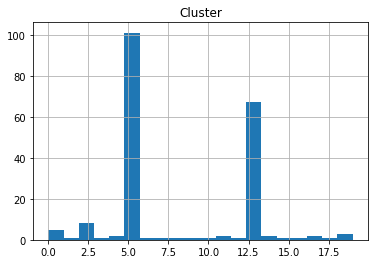

In [36]:
mantor_cluster.hist(column='Cluster', bins=20)

#####  KMeans returns clutering that's disproportional

##### VERSION 2: K-NEAREST NEIGHBOR - KNN

RUN KMEANS FOR MANHATTAN AND TORONTO SEPARATELY - to understand the clustering neighborhood within each city
CONCAT THE TWO CITIES - to make sure that unique venue categories that only appear in one city is captured in the analysis of each city
RUN ONE HOT ENCODING ON THE CONCATENATED DATAFRAME - assigns an interger value for each venue category
CREATE NEW TORONTO DF BY DROPPING ROWS WHERE CITY IS MANHATTAN - this can be the training set when we fit manhattan into toronto, and the prediction set for finding knn for toronto neighborhoods in manhattan
CREAT NEW MANHATTAN DF BY DROPPING ROWS WHERE CITY IS TORONTO - this can be the training set when we fit toronto into manhattan, and the prediction set for finding knn for manhattan neighborhoods in toronto
RUN K NEAREST NEIGHBOR

###### RUN KMEANS FOR MANHATTAN AND TORONTO SEPARATELY - to understand the clustering neighborhood within each city

In [37]:
man_grouped = mantor_grouped[mantor_grouped['Zity'] == 'Manhattan'].reset_index(drop=True)
print(man_grouped.shape)

(110, 431)


In [38]:
# set number of clusters
kclusters = 10

man_grouped_clustering = man_grouped.drop(['Zity', 'Zeighborhood'], 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=12, random_state=0).fit(man_grouped_clustering)

# check cluster labels generated for each row in the dataframe
man_labels = kmeans.labels_
man_labels [0:10]

array([6, 7, 1, 1, 4, 5, 1, 6, 6, 6], dtype=int32)

In [39]:
# add clustering labels
man_cluster = man_grouped
man_cluster["Cluster"] = man_labels

man_fixed_columns_cluster = [man_cluster.columns[-1]] + list(man_cluster.columns[:-1])
man_cluster = man_cluster[man_fixed_columns_cluster]

man_cluster.head()

,Cluster,Zity,Zeighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b40f32ba8>]],
      dtype=object)

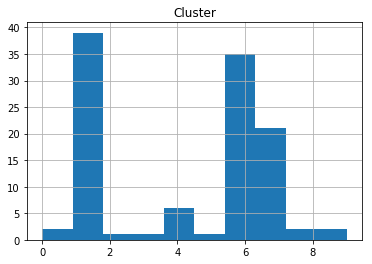

In [43]:
man_cluster.hist(column='Cluster', bins=10)

In [40]:
tor_grouped = mantor_grouped[mantor_grouped['Zity'] == 'Toronto'].reset_index(drop=True)
print(tor_grouped.shape)

(93, 431)


In [41]:
tor_grouped_clustering = tor_grouped.drop(['Zity', 'Zeighborhood'], 1)

# run k-means clustering
tor_kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=12, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
tor_labels = tor_kmeans.labels_
tor_labels [0:10]

array([4, 5, 4, 0, 0, 0, 0, 0, 4, 0], dtype=int32)

In [42]:
# add clustering labels
tor_cluster = tor_grouped
tor_cluster["Cluster"] = tor_labels

tor_fixed_columns_cluster = [tor_cluster.columns[-1]] + list(tor_cluster.columns[:-1])
tor_cluster = tor_cluster[tor_fixed_columns_cluster]

tor_cluster.head()

,Cluster,Zity,Zeighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b40e5ec50>]],
      dtype=object)

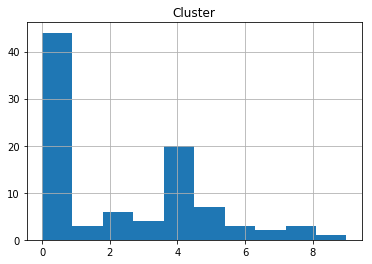

In [44]:
tor_cluster.hist(column='Cluster', bins=10)

###### Use man_grouped_clustering and tor_grouped_clustering to run KNN 

In [45]:
man_grouped.head()
print(man_grouped.shape)

(110, 431)


In [46]:
tor_grouped.head()
print(tor_grouped.shape)

(93, 431)


In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
man_y = man_labels #the target field are the labels determined in KMeans
man_y[0:10]

array([6, 7, 1, 1, 4, 5, 1, 6, 6, 6], dtype=int32)

In [50]:
k = 4
#Train Manhattan Model 
man_neigh = KNeighborsClassifier(n_neighbors = k).fit(man_grouped_clustering, man_y)
man_neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [51]:
#predict toronto labels using the man_neigh model
tor_yhat = man_neigh.predict(tor_grouped_clustering)
tor_yhat[0:10]

array([6, 1, 6, 1, 1, 7, 1, 1, 6, 1], dtype=int32)

In [52]:
# add clustering labels
tor_knncluster = tor_grouped
tor_knncluster["Cluster"] = tor_yhat

tor_fixed_columns_knncluster = [tor_knncluster.columns[-1]] + list(tor_knncluster.columns[:-1])
tor_knncluster = tor_knncluster[tor_fixed_columns_knncluster]

tor_knncluster.head()

,Cluster,Zity,Zeighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b40d78898>]],
      dtype=object)

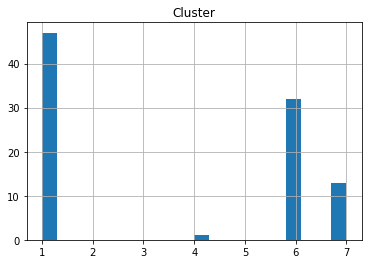

In [53]:
tor_knncluster.hist(column='Cluster', bins=10)

##### Now run the opposite scenario

In [54]:
tor_y = tor_labels #the target field are the labels determined in KMeans
tor_y[0:10]

array([4, 5, 4, 0, 0, 0, 0, 0, 4, 0], dtype=int32)

In [55]:
k = 4
#Train Toronto Model 
tor_neigh = KNeighborsClassifier(n_neighbors = k).fit(tor_grouped_clustering, tor_y)
tor_neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [56]:
#predict manhattan labels using the tor_neigh model
man_yhat = tor_neigh.predict(man_grouped_clustering)
man_yhat[0:10]

array([4, 0, 0, 0, 4, 4, 0, 4, 4, 4], dtype=int32)

In [57]:
# add clustering labels
man_knncluster = man_grouped
man_knncluster["Cluster"] = man_yhat

man_fixed_columns_knncluster = [man_knncluster.columns[-1]] + list(man_knncluster.columns[:-1])
man_knncluster = man_knncluster[man_fixed_columns_knncluster]

man_knncluster.head()

,Cluster,Zity,Zeighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b40d18ef0>]],
      dtype=object)

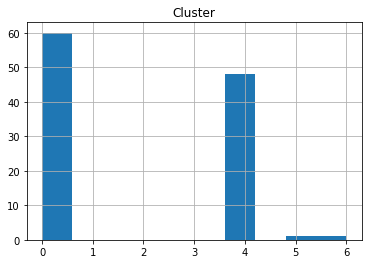

In [58]:
man_knncluster.hist(column='Cluster', bins=10)

##### Let's ONLY use tor_knncluster vs. man_cluster for our comparison

### Visualizations

In [59]:
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: done

# All requested packages already installed.

Folium installed and imported!


#### Create a cluster map for each city

In [60]:
man_cluster_new = man_cluster[['Cluster', 'Zeighborhood']].copy()
man_cluster_new = man_cluster_new.rename(columns={'Zeighborhood': 'Neighborhood'})
man_cluster_new.head()

,Cluster,Neighborhood
0,6,Bath Beach
1,7,Battery Park City
2,1,Bay Ridge
3,1,Bedford Stuyvesant
4,4,Bensonhurst


In [61]:
man_geo = man_neighborhoods
print(man_geo.shape)

(110, 4)


In [62]:
man_geo_merged = man_geo.join(man_cluster_new.set_index('Neighborhood'), on='Neighborhood')

man_geo_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster
0,Manhattan,Marble Hill,40.876551,-73.910660,1
1,Brooklyn,Bay Ridge,40.625801,-74.030621,1
2,Brooklyn,Bensonhurst,40.611009,-73.995180,4
3,Brooklyn,Sunset Park,40.645103,-74.010316,6
4,Brooklyn,Greenpoint,40.730201,-73.954241,1


In [63]:
# create ny map
man_map_clusters = folium.Map(location=[man_latitude, man_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(man_geo_merged['Latitude'], man_geo_merged['Longitude'], man_geo_merged['Neighborhood'], man_geo_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(man_map_clusters)
       
man_map_clusters

In [64]:
tor_cluster_new = tor_knncluster[['Cluster', 'Zeighborhood']].copy()
tor_cluster_new = tor_cluster_new.rename(columns={'Zeighborhood': 'Neighborhood'})
print(tor_cluster_new.shape)
tor_cluster_new.head()

(93, 2)


,Cluster,Neighborhood
0,6,Agincourt
1,1,"Alderwood, Long Branch"
2,6,"Bathurst Manor, Wilson Heights, Downsview North"
3,1,Bayview Village
4,1,"Bedford Park, Lawrence Manor East"


In [65]:
tor_geo_merged = df_tor.drop(['Postal Code'], 1)
tor_geo_merged = tor_geo_merged.rename(columns={'Neighbourhood': 'Neighborhood'})
tor_geo_merged = tor_geo_merged.join(tor_cluster_new.set_index('Neighborhood'), on='Neighborhood')
tor_geo_merged = tor_geo_merged[tor_geo_merged['Cluster'].notna()]
print(tor_geo_merged.shape)
tor_geo_merged

(97, 5)


,Borough,Neighborhood,Latitude,Longitude,Cluster
0,North York,Parkwoods,43.753259,-79.329656,6.0
1,North York,Victoria Village,43.725882,-79.315572,1.0
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,7.0
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,7.0
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0
6,Scarborough,"Malvern, Rouge",43.806686,-79.194353,6.0
7,North York,Don Mills,43.745906,-79.352188,1.0
8,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,1.0
9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,7.0
10,North York,Glencairn,43.709577,-79.445073,7.0


In [66]:
tor_geo_merged['Cluster'] = tor_geo_merged['Cluster'].astype(int)
tor_geo_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster
0,North York,Parkwoods,43.753259,-79.329656,6
1,North York,Victoria Village,43.725882,-79.315572,1
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,7
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,7
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1


In [67]:
# create ny map
tor_map_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_geo_merged['Latitude'], tor_geo_merged['Longitude'], tor_geo_merged['Neighborhood'], tor_geo_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tor_map_clusters)
       
tor_map_clusters

### Examine Clusters

In [69]:
#concatenate two cities' neighborhood clusters
mantor_geo_merged = pd.concat([man_geo_merged, tor_geo_merged])
mantor_geo_merged = mantor_geo_merged.reset_index()
mantor_geo_merged

,index,Borough,Neighborhood,Latitude,Longitude,Cluster
0,0,Manhattan,Marble Hill,40.876551,-73.910660,1
1,1,Brooklyn,Bay Ridge,40.625801,-74.030621,1
2,2,Brooklyn,Bensonhurst,40.611009,-73.995180,4
3,3,Brooklyn,Sunset Park,40.645103,-74.010316,6
4,4,Brooklyn,Greenpoint,40.730201,-73.954241,1
5,5,Brooklyn,Gravesend,40.595260,-73.973471,4
6,6,Brooklyn,Brighton Beach,40.576825,-73.965094,6
7,7,Brooklyn,Sheepshead Bay,40.586890,-73.943186,1
8,8,Brooklyn,Manhattan Terrace,40.614433,-73.957438,4
9,9,Brooklyn,Flatbush,40.636326,-73.958401,6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b40876668>]],
      dtype=object)

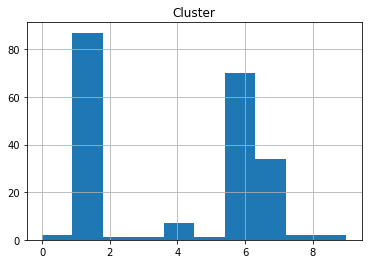

In [70]:
mantor_geo_merged.hist(column='Cluster', bins=10)

In [71]:
# CLUSTER 0
mantor_0 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 0]
print (mantor_0.shape)
mantor_0

(2, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
29,29,Brooklyn,Canarsie,40.635564,-73.902093,0
93,93,Brooklyn,Paerdegat Basin,40.631318,-73.902335,0


In [72]:
# CLUSTER 1
mantor_1 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 1]
print (mantor_1.shape)
mantor_1

(87, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
0,0,Manhattan,Marble Hill,40.876551,-73.910660,1
1,1,Brooklyn,Bay Ridge,40.625801,-74.030621,1
4,4,Brooklyn,Greenpoint,40.730201,-73.954241,1
7,7,Brooklyn,Sheepshead Bay,40.586890,-73.943186,1
13,13,Brooklyn,Windsor Terrace,40.656946,-73.980073,1
14,14,Brooklyn,Prospect Heights,40.676822,-73.964859,1
16,16,Brooklyn,Williamsburg,40.707144,-73.958115,1
17,17,Brooklyn,Bushwick,40.698116,-73.925258,1
18,18,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,1
19,19,Brooklyn,Brooklyn Heights,40.695864,-73.993782,1


In [73]:
# CLUSTER 2
mantor_2 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 2]
print (mantor_2.shape)
mantor_2

(1, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
31,31,Brooklyn,Mill Island,40.606336,-73.908186,2


In [74]:
# CLUSTER 3
mantor_3 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 3]
print (mantor_3.shape)
mantor_3

(1, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
47,47,Brooklyn,Midwood,40.625596,-73.957595,3


In [75]:
# CLUSTER 4
mantor_4 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 4]
print (mantor_4.shape)
mantor_4

(7, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
2,2,Brooklyn,Bensonhurst,40.611009,-73.995180,4
5,5,Brooklyn,Gravesend,40.595260,-73.973471,4
8,8,Brooklyn,Manhattan Terrace,40.614433,-73.957438,4
38,38,Brooklyn,Marine Park,40.609748,-73.931344,4
94,94,Brooklyn,Mill Basin,40.615974,-73.915154,4
107,107,Brooklyn,Madison,40.609378,-73.948415,4
157,50,North York,Humber Summit,43.756303,-79.565963,4


In [76]:
# CLUSTER 5
mantor_5 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 5]
print (mantor_5.shape)
mantor_5

(1, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
46,46,Brooklyn,Bergen Beach,40.61515,-73.898556,5


In [77]:
# CLUSTER 6
mantor_6 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 6]
print (mantor_6.shape)
mantor_6

(70, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
3,3,Brooklyn,Sunset Park,40.645103,-74.010316,6
6,6,Brooklyn,Brighton Beach,40.576825,-73.965094,6
9,9,Brooklyn,Flatbush,40.636326,-73.958401,6
10,10,Brooklyn,Crown Heights,40.670829,-73.943291,6
11,11,Brooklyn,East Flatbush,40.641718,-73.936103,6
12,12,Brooklyn,Kensington,40.642382,-73.980421,6
15,15,Brooklyn,Brownsville,40.663950,-73.910235,6
26,26,Brooklyn,Cypress Hills,40.682391,-73.876616,6
27,27,Brooklyn,East New York,40.669926,-73.880699,6
33,33,Brooklyn,Coney Island,40.574293,-73.988683,6


In [79]:
# CLUSTER 7
mantor_7 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 7]
print (mantor_7.shape)
mantor_7

(34, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
62,62,Manhattan,Upper East Side,40.775639,-73.960508,7
65,65,Manhattan,Roosevelt Island,40.762160,-73.949168,7
67,67,Manhattan,Lincoln Square,40.773529,-73.985338,7
68,68,Manhattan,Clinton,40.759101,-73.996119,7
69,69,Manhattan,Midtown,40.754691,-73.981669,7
71,71,Manhattan,Chelsea,40.744035,-74.003116,7
72,72,Manhattan,Greenwich Village,40.726933,-73.999914,7
75,75,Manhattan,Tribeca,40.721522,-74.010683,7
77,77,Manhattan,Soho,40.722184,-74.000657,7
78,78,Manhattan,West Village,40.734434,-74.006180,7


In [80]:
# CLUSTER 8
mantor_8 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 8]
print (mantor_8.shape)
mantor_8

(2, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
28,28,Brooklyn,Starrett City,40.647589,-73.879370,8
40,40,Brooklyn,Sea Gate,40.576375,-74.007873,8


In [81]:
# CLUSTER 9
mantor_9 = mantor_geo_merged.loc[mantor_geo_merged['Cluster'] == 9]
print (mantor_9.shape)
mantor_9

(2, 6)


,index,Borough,Neighborhood,Latitude,Longitude,Cluster
30,30,Brooklyn,Flatlands,40.630446,-73.929113,9
91,91,Brooklyn,Remsen Village,40.652117,-73.916653,9
